In [1]:
# Leave lines below uncommented this if you get:
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys

In [2]:
from glomerulus import Glomerulus, Patch, KidneySampleDataset, generate_patches
from networks import CBAM_R2UNet_v2
from losses import bce_dice_loss
from trainer import train

In [3]:
patch_size = 512

In [4]:
# Load small dataset
dataset_path = './sampled_data/0.6_0.4_1000.npy'
dataset = KidneySampleDataset()
dataset.load(dataset_path)

# Split dataset into train, val
train_dataset, val_dataset = dataset.split([0.8, 0.2])
del dataset
print(f'Train: {len(train_dataset)}, Val: {len(val_dataset)}')

Train: 800, Val: 200


In [5]:
# Create Dataloaders
batch_size = 16
num_workers = 8
prefetch_factor = 1

# For Linux
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, prefetch_factor=1)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, prefetch_factor=1)

# For Windows
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Define Model
model_name = f'CBAM_R2UNet_v2_BCE_{batch_size}'
loss_name = 'Weighted_BCE_Dice'
model_resolution = 128
model = CBAM_R2UNet_v2((model_resolution, model_resolution), (patch_size, patch_size)).cuda()

# Define Criterion/Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [7]:
model, train_loss, val_loss = train(model, model_name, './models', train_dataloader, val_dataloader, criterion, optimizer, epochs=100)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

/home/patipol/Documents/automated-visual-acuity-tester/HUBMAP/trainer.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.unsqueeze(torch.tensor(inputs.type(dtype)), axis=1)
/home/patipol/Documents/automated-visual-acuity-tester/HUBMAP/trainer.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.unsqueeze(torch.tensor(labels.type(dtype)), axis=1)
/home/patipol/Documents/automated-visual-acuity-tester/HUBMAP/trainer.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.unsqueeze(torch.tensor(inp

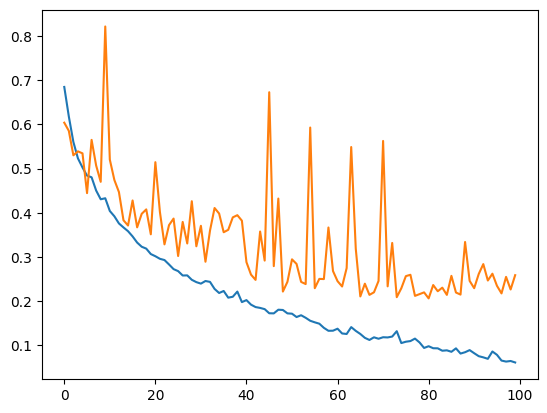

In [8]:
plt.plot(train_loss)
plt.plot(val_loss)

In [9]:
# Retrain with lowered learning rate

# Define Model
model_name = f'CBAM_R2UNet_v2_BCE_retrained_{batch_size}'

# Define Criterion/Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

model, train_loss, val_loss = train(model, model_name, './models', train_dataloader, val_dataloader, criterion, optimizer, epochs=100)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
from networks import CBAM_R2UNet_v2_Large
# Define Model
model_name = f'CBAM_R2UNet_v2_Large_BCE_Dice_{batch_size}'
model_resolution = 256
model = CBAM_R2UNet_v2_Large((model_resolution, model_resolution), (patch_size, patch_size)).cuda()
model.load_state_dict(torch.load(f'./models/CBAM_R2UNet_v2_Large_256_train_0.6_0.4.npy_Weighted_BCE_Dice_lr0.001_t1000_b16_best_loss.npz'))

# Define Criterion/Loss function and optimizer
criterion = bce_dice_loss
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-6)

model, train_loss, val_loss = train(model, model_name, './models', train_dataloader, val_dataloader, criterion, optimizer, epochs=100)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)

In [ ]:
patches = []
dataset_dir = './samples_dataset'

for ratio in range(0, 11):
    glomerulus_patch_ratio = np.round(ratio/10, 1)
    random_patch_ratio = np.round(1 - glomerulus_patch_ratio, 1)

    # Iterate through all images used for training
    for idx, image_name in enumerate(tqdm(train_image_names, desc='Loading Train Images')):
        image_path = os.path.join(root_dir, f'{image_name}.tiff')
        label_path = os.path.join(root_dir, f'{image_name}.json')
        try:
            # Sample patches from the image
            patches = generate_patches(
                patch_size = patch_size,
                num_samples = num_train_samples,
                image_path = image_path,
                label_path = label_path,
                # Dataset ratio config
                glomerulus_patch_ratio = glomerulus_patch_ratio,
                random_patch_ratio = random_patch_ratio,
                empty_patch = 0
            )
            
            # Create a dataset object from sampled patches and save as temp file (to save RAM when loading new imgs)
            dataset = KidneySampleDataset(patches)
            dataset.save(os.path.join(dataset_dir, f'train_chunk_{idx}.npy'))
        except:
            print('Error generating patches {image_path}')
            
    # Read saved temp dataset chunks and append as 1 single dataset
    train_dataset = KidneySampleDataset()
    for idx in tqdm(range(len(train_image_names)), desc='Appending Generated Datasets'):
        tmp_dataset = KidneySampleDataset()
        try:
            tmp_dataset.load(os.path.join(dataset_dir, f'train_chunk_{idx}.npy'))
            train_dataset.append_data(tmp_dataset)
        except:
            print(f'Error loading chunk {idx}')
    train_dataset.save(os.path.join(dataset_dir, f'train_{str(glomerulus_patch_ratio)}_{str(random_patch_ratio)}.npy'))

glomerulus_patch_ratio = 0
random_patch_ratio = 1
            
# Iterate through all images used for validating
for idx, image_name in enumerate(tqdm(val_image_names, desc='Loading Val Images')):
    image_path = os.path.join(root_dir, f'{image_name}.tiff')
    label_path = os.path.join(root_dir, f'{image_name}.json')
    try:
        # Sample patches from the image
        patches = generate_patches(
            patch_size = patch_size,
            num_samples = num_val_samples,
            image_path = image_path,
            label_path = label_path,
            # Dataset ratio config
            glomerulus_patch_ratio = glomerulus_patch_ratio,
            random_patch_ratio = random_patch_ratio,
            empty_patch = 0
        )
        
        # Create a dataset object from sampled patches and save as temp file (to save RAM when loading new imgs)
        dataset = KidneySampleDataset(patches)
        dataset.save(os.path.join(dataset_dir, f'val_chunk_{idx}.npy'))
    except:
        print('Error generating patches {image_path}')
        
# Read saved temp dataset chunks and append as 1 single dataset
val_dataset = KidneySampleDataset()
for idx in tqdm(range(len(val_image_names)), desc='Appending Generated Datasets'):
    tmp_dataset = KidneySampleDataset()
    try:
        tmp_dataset.load(os.path.join(dataset_dir, f'val_chunk_{idx}.npy'))
        val_dataset.append_data(tmp_dataset)
    except:
        print(f'Error loading chunk {idx}')
val_dataset.save(os.path.join(dataset_dir, f'val.npy'))

Loading Train Images:   0%|          | 0/1 [00:00<?, ?it/s]

/home/patipol/Documents/automated-visual-acuity-tester/speech-model/whisper_env/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Rendering Patches:   0%|          | 0/1000 [00:00<?, ?it/s]

Appending Generated Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

Loading Train Images:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
import torch.optim as optim
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader
import json
import gc

In [5]:
batch_size = 16
model_resolution = 256

model_name = 'CBAM_R2UNet_v2_Large_rdn_data'
loss_name = 'Weighted_BCE_Dice'


dtype = torch.cuda.FloatTensor

In [6]:
def train(model, train_dataloader, val_dataloader, label_mean, epochs=100):
    gc.collect()
    torch.cuda.empty_cache()
    
    best_weights = None
    best_loss = 10000000
    lr = 0.0005
    
    train_loss = []
    val_loss = []
    

    criterion = bce_weighted_dice_loss
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-6)
    pbar = tqdm(total=epochs, desc='Training')
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        
        for inputs, labels in train_dataloader:
            gc.collect()
            torch.cuda.empty_cache()
            # Move data to GPU
            inputs = torch.unsqueeze(torch.tensor(inputs.type(dtype)), axis=1)
            labels = torch.unsqueeze(torch.tensor(labels.type(dtype)), axis=1)
            optimizer.zero_grad()
            # Run model
            outputs = model.forward(inputs)

            loss = criterion(outputs, labels, [1-label_mean, label_mean]).cuda()
            
            loss.backward()

            running_loss += loss.item()
            optimizer.step()
            
        train_epoch_loss = running_loss / len(train_dataloader)
        train_loss.append(train_epoch_loss)

        # Val
        model.eval()
        running_loss = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                gc.collect()
                torch.cuda.empty_cache()
                # Move data to GPU
                inputs = torch.unsqueeze(torch.tensor(inputs.type(dtype)), axis=1)
                labels = torch.unsqueeze(torch.tensor(labels.type(dtype)), axis=1)
                # Run model
                outputs = model.forward(inputs)

                loss = criterion(outputs, labels, [1-label_mean, label_mean]).cuda()
                running_loss += loss.item()
        val_epoch_loss = running_loss / len(val_dataloader)
        val_loss.append(val_epoch_loss)
        
        # Save model every 10 epochs
        # if (epoch+1)%10 == 0:
        # torch.save(model.state_dict(), f'./models/{model_name}_{loss_name}_t{str(num_train_samples)}_b{str(batch_size)}_{str(epoch+1)}.npz')
            
        # Keep track of best weights
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_weights = model.state_dict()
            
        pbar.set_postfix({'TL': train_epoch_loss, 'VL': val_epoch_loss, 'BV': best_loss})
        pbar.update(1)
    # Save weights with best loss
    torch.save(best_weights, f'./models/{model_name}_{loss_name}_lr0.0005_t{str(num_train_samples)}_b{str(batch_size)}_best_loss.npz')
    return model, train_loss, val_loss

In [8]:
# Load Val dataset
for file_name in os.listdir(dataset_dir):
    if 'chunk' in file_name:
        pass
    if 'val' in file_name:
        file_path = os.path.join(dataset_dir, file_name)
        
        val_dataset = KidneySampleDataset()
        val_dataset.load(file_path)
        
# Run training for each dataset file
for file_name in os.listdir(dataset_dir):
    if 'chunk' in file_name:
        pass
    if 'train' in file_name:
        torch.cuda.empty_cache()
        model_name = f'CBAM_R2UNet_v2_Large_{model_resolution}_{file_name}'

        file_path = os.path.join(dataset_dir, file_name)

        train_dataset = KidneySampleDataset()
        train_dataset.load(file_path)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, prefetch_factor=1)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8, prefetch_factor=1)

        model = CBAM_R2UNet_v2_Large((model_resolution, model_resolution), (patch_size, patch_size)).cuda()

        model, train_loss, val_loss = train(model, train_dataloader, val_dataloader, 0.5, epochs=100)

        with open(f'./models/{model_name}_{loss_name}_lr0.001_t{str(num_train_samples)}_b{str(batch_size)}_train_loss.json', 'w') as f:
            json.dump(train_loss, f, indent=2) 
        
        with open(f'./models/{model_name}_{loss_name}_lr0.001_t{str(num_train_samples)}_b{str(batch_size)}_val_loss.json', 'w') as f:
            json.dump(val_loss, f, indent=2) 

Training:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_1331702/1698414634.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.unsqueeze(torch.tensor(inputs.type(dtype)), axis=1)
/tmp/ipykernel_1331702/1698414634.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.unsqueeze(torch.tensor(labels.type(dtype)), axis=1)


KeyboardInterrupt: 

In [9]:
# Load saved epoch losses
train_losses = []
val_losses = []
for file_name in os.listdir('./models'):
    if '.json' in file_name and not 'chunk' in file_name:
        file_path = os.path.join('./models', file_name)
        ratio = f'glo={file_name.split("_")[4]}, rnd={".".join(file_name.split("_")[5].split(".")[:2])}'
        loss = json.load(open(file_path, 'r'))

        if 'train_loss' in file_name:
            train_losses.append({
                'config': ratio,
                'losses': loss
            })
        elif 'val_loss' in file_name:
            val_losses.append({
                'config': ratio,
                'losses': loss
            })

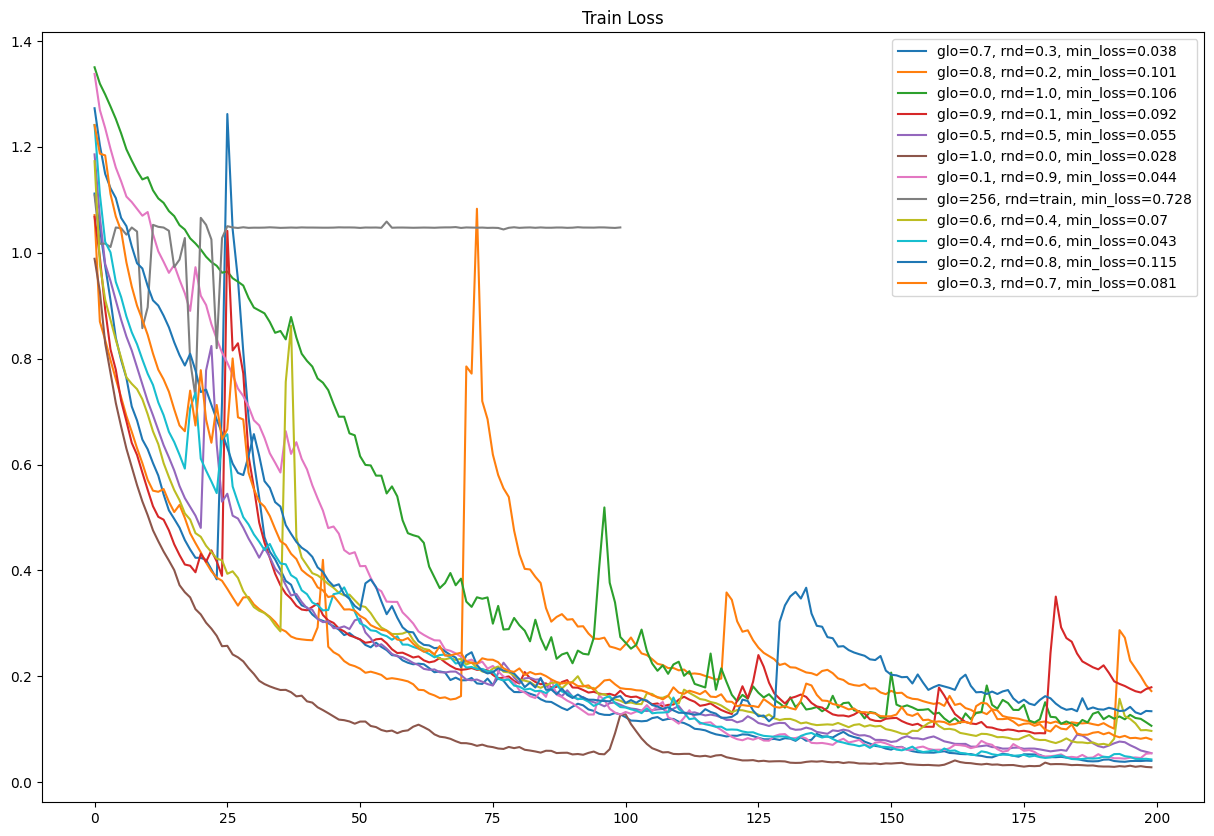

In [10]:
# Plot train loss
plt.figure(figsize=(15, 10))
for train_loss in train_losses:
    plt.plot(train_loss['losses'], label=f'{train_loss["config"]}, min_loss={np.round(min(train_loss["losses"]),3)}')
plt.title('Train Loss')
plt.legend()

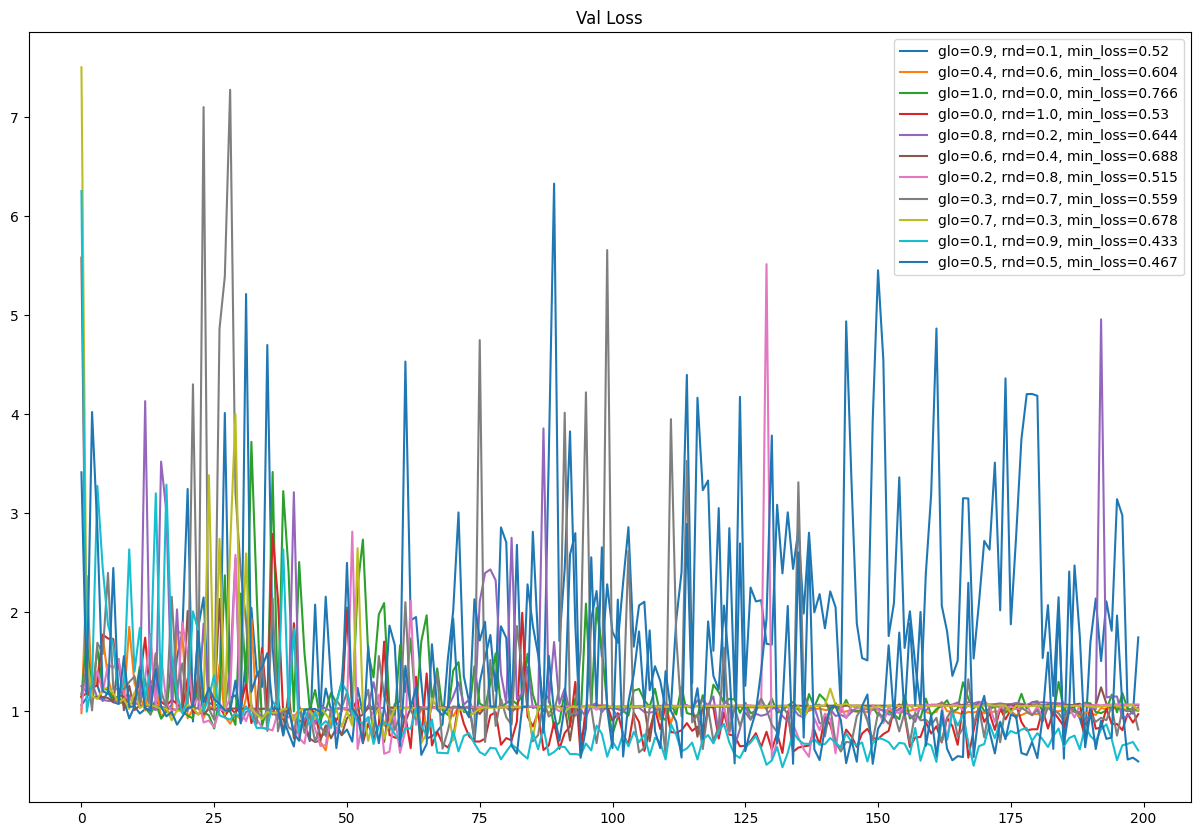

In [49]:
# Plot val loss
plt.figure(figsize=(15, 10))
for val_loss in val_losses:
    plt.plot(val_loss['losses'], label=f'{val_loss["config"]}, min_loss={np.round(min(val_loss["losses"]),3)}')
plt.title('Val Loss')
plt.legend()

In [7]:
# Load Val dataset
for file_name in os.listdir(dataset_dir):
    if 'chunk' in file_name:
        pass
    if 'val' in file_name:
        file_path = os.path.join(dataset_dir, file_name)
        
        val_dataset = KidneySampleDataset()
        val_dataset.load(file_path)
        
# Run training for each dataset file
for file_name in os.listdir(dataset_dir):
    if 'chunk' in file_name:
        pass
    if 'train' in file_name and '0.0_1.0' in file_name:
        torch.cuda.empty_cache()
        model_name = f'CBAM_R2UNet_v2_Large_{model_resolution}_{file_name}_extended'

        file_path = os.path.join(dataset_dir, file_name)

        train_dataset = KidneySampleDataset()
        train_dataset.load(file_path)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, prefetch_factor=1)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8, prefetch_factor=1)

        model = CBAM_R2UNet_v2_Large((model_resolution, model_resolution), (patch_size, patch_size)).cuda()
        model.load_state_dict(torch.load('./models/CBAM_R2UNet_v2_Large_256_train_0.6_0.4.npy_Weighted_BCE_Dice_lr0.001_t1000_b16_best_loss.npz'))

        model, train_loss, val_loss = train(model, train_dataloader, val_dataloader, 0.5, epochs=200)

        with open(f'./models/{model_name}_{loss_name}_lr0.0005_t{str(num_train_samples)}_b{str(batch_size)}_train_loss.json', 'w') as f:
            json.dump(train_loss, f, indent=2) 
        
        with open(f'./models/{model_name}_{loss_name}_lr0.0005_t{str(num_train_samples)}_b{str(batch_size)}_val_loss.json', 'w') as f:
            json.dump(val_loss, f, indent=2) 

Training:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_1457294/3070822164.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.unsqueeze(torch.tensor(inputs.type(dtype)), axis=1)
/tmp/ipykernel_1457294/3070822164.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.unsqueeze(torch.tensor(labels.type(dtype)), axis=1)
/tmp/ipykernel_1457294/3070822164.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.unsqueeze(torch.tensor(inputs.type(dtype)), axis=1)
/tmp/ipykernel_1457294/3070822164.py:50: UserWarning: To copy construct from a ten